In [1]:
%matplotlib inline


# Plotting data from a file

Plotting CPU usage values


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from glob import glob
from sklearn.metrics import auc

Helper functions
===========================

In [3]:
def get_relative_time_in_mins(start_time, data):
    # relative_time = round((data - start_time).dt.total_seconds() / 60.0, 1)
    relative_time = data - start_time
    return relative_time

Function to load CPU data
=====================

In [4]:
def load_cpu_data_from_csv(user_offset=0, skip_offset_for_mode="default"):
    task_tot_cpu_filenames = glob("taskmanager_System_CPU_Usage_*.csv")
    n_schedule_types = len(task_tot_cpu_filenames)
    task_tot_cpu_data = [None] * n_schedule_types
    for idx, f in enumerate(task_tot_cpu_filenames):
        schedule_mode = f.split("_")[4]
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print("Reading " + f + " into index " + str(idx))
        task_tot_cpu_data[idx] = pd.read_csv(f)
        task_tot_cpu_data[idx]["schedule_mode"] = schedule_mode

    for cpu_usage_dataset in task_tot_cpu_data:
        start_offset = 0
        if cpu_usage_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            cpu_usage_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        cpu_usage_dataset["time"] = pd.to_datetime(
            cpu_usage_dataset["time"], unit="ns", utc=True
        )
        cpu_usage_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, cpu_usage_dataset["time"]
        )
        cpu_usage_dataset["formatted_time"] = cpu_usage_dataset["time"].dt.strftime(
            "%H:%M:%S"
        )

    # Read individual CPU data
    individual_cpu_filenames = glob("jobmanager_System_CPU_UsageCPU*.csv")
    individual_cpu_data = pd.DataFrame()
    schedule_modes = []
    for idx, f in enumerate(individual_cpu_filenames):
        individual_cpu_dataset = pd.read_csv(f)
        schedule_mode = f.split("_")[4]
        if schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
        individual_cpu_dataset["schedule_mode"] = schedule_mode
        schedule_modes.append(schedule_mode)

        start_time = pd.to_datetime(
            individual_cpu_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        individual_cpu_dataset["time"] = pd.to_datetime(
            individual_cpu_dataset["time"], unit="ns", utc=True
        )
        individual_cpu_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, individual_cpu_dataset["time"]
        )
        individual_cpu_dataset["formatted_time"] = individual_cpu_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

        cpu_id = individual_cpu_dataset.name.iloc[0].partition(
            "taskmanager_System_CPU_UsageCPU"
        )[-1]
        cpu_usage_name = "CPU " + cpu_id.rjust(2, "0") + " Usage"
        individual_cpu_dataset["cpu_id"] = int(cpu_id)
        individual_cpu_dataset["cpu_usage_name"] = cpu_usage_name
        if individual_cpu_data.empty:
            individual_cpu_data = individual_cpu_dataset
        else:
            individual_cpu_data = individual_cpu_data.append(individual_cpu_dataset)

    return task_tot_cpu_data, individual_cpu_data, set(schedule_modes)

Function to load operator data
=========================

In [5]:
def load_operator_data_from_csv(user_offset=0, skip_offset_for_mode="default"):
    task_operator_cpu_filenames = glob(
        "taskmanager_job_task_operator_currentCpuUsage_*.csv"
    )
    n_schedule_types = len(task_operator_cpu_filenames)
    task_operator_cpu_data = [None] * n_schedule_types
    for idx, f in enumerate(task_operator_cpu_filenames):
        schedule_mode = f.split("_")[5]
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print(
            "Reading "
            + f
            + " into index "
            + str(idx)
            + " with schedule mode "
            + schedule_mode
        )
        task_operator_cpu_data[idx] = pd.read_csv(f)
        task_operator_cpu_data[idx]["schedule_mode"] = schedule_mode

    for operator_cpu_dataset in task_operator_cpu_data:
        start_offset = 0
        if operator_cpu_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            operator_cpu_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        operator_cpu_dataset["time"] = pd.to_datetime(
            operator_cpu_dataset["time"], unit="ns", utc=True
        )
        operator_cpu_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, operator_cpu_dataset["time"]
        )
        operator_cpu_dataset["formatted_time"] = operator_cpu_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

    task_operator_rec_in_filenames = glob(
        "taskmanager_job_task_operator_numRecordsInPerSecond_*.csv"
    )
    task_operator_rec_in_data = [None] * n_schedule_types
    for idx, f in enumerate(task_operator_rec_in_filenames):
        schedule_mode = f.split("_")[5]
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print(
            "Reading "
            + f
            + " into index "
            + str(idx)
            + " with schedule mode "
            + schedule_mode
        )
        task_operator_rec_in_data[idx] = pd.read_csv(f)
        task_operator_rec_in_data[idx]["schedule_mode"] = schedule_mode

    for operator_rec_in_dataset in task_operator_rec_in_data:
        start_offset = 0
        if operator_rec_in_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            operator_rec_in_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        operator_rec_in_dataset["time"] = pd.to_datetime(
            operator_rec_in_dataset["time"], unit="ns", utc=True
        )
        operator_rec_in_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, operator_rec_in_dataset["time"]
        )
        operator_rec_in_dataset["formatted_time"] = operator_rec_in_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

    task_operator_rec_out_filenames = glob(
        "taskmanager_job_task_operator_numRecordsOutPerSecond_*.csv"
    )
    task_operator_rec_out_data = [None] * n_schedule_types
    for idx, f in enumerate(task_operator_rec_out_filenames):
        schedule_mode = f.split("_")[5]
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print(
            "Reading "
            + f
            + " into index "
            + str(idx)
            + " with schedule mode "
            + schedule_mode
        )
        task_operator_rec_out_data[idx] = pd.read_csv(f)
        task_operator_rec_out_data[idx]["schedule_mode"] = schedule_mode

    for operator_rec_out_dataset in task_operator_rec_out_data:
        start_offset = 0
        if operator_rec_out_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            operator_rec_out_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        operator_rec_out_dataset["time"] = pd.to_datetime(
            operator_rec_out_dataset["time"], unit="ns", utc=True
        )
        operator_rec_out_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, operator_rec_out_dataset["time"]
        )
        operator_rec_out_dataset["formatted_time"] = operator_rec_out_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

    task_operator_rec_proc_filenames = glob(
        "taskmanager_job_task_operator_numRecordsProcessedPerSecond_*.csv"
    )
    task_operator_rec_proc_data = [None] * n_schedule_types
    for idx, f in enumerate(task_operator_rec_proc_filenames):
        schedule_mode = f.split("_")[5]
        idx = 0
        if schedule_mode == "traffic-based":
            idx = 1
        elif schedule_mode == "drl-based":
            schedule_mode = "Q-actor-critic"
            idx = 2
        elif schedule_mode == "adaptive":
            schedule_mode = "actor-critic-NN"
            idx = 3
        print(
            "Reading "
            + f
            + " into index "
            + str(idx)
            + " with schedule mode "
            + schedule_mode
        )
        task_operator_rec_proc_data[idx] = pd.read_csv(f)
        task_operator_rec_proc_data[idx]["schedule_mode"] = schedule_mode

    for operator_rec_proc_dataset in task_operator_rec_proc_data:
        start_offset = 0
        if operator_rec_proc_dataset["schedule_mode"].any() != skip_offset_for_mode:
            start_offset = user_offset
        start_time = pd.to_datetime(
            operator_rec_proc_dataset.iloc[start_offset]["time"], unit="ns", utc=True
        )
        operator_rec_proc_dataset["time"] = pd.to_datetime(
            operator_rec_proc_dataset["time"], unit="ns", utc=True
        )
        operator_rec_proc_dataset["rel_time"] = get_relative_time_in_mins(
            start_time, operator_rec_proc_dataset["time"]
        )
        operator_rec_proc_dataset["formatted_time"] = operator_rec_proc_dataset[
            "time"
        ].dt.strftime("%H:%M:%S")

    return (
        task_operator_cpu_data,
        task_operator_rec_in_data,
        task_operator_rec_out_data,
        task_operator_rec_proc_data,
    )

In [6]:
task_tot_cpu_data, individual_cpu_data, schedule_modes = load_cpu_data_from_csv(0)
task_tot_cpu_data[1]

Reading taskmanager_System_CPU_Usage_default_2021_03_29.csv into index 0
Reading taskmanager_System_CPU_Usage_traffic-based_2021_03_29.csv into index 1


,name,time,host,tm_id,value,schedule_mode,rel_time,formatted_time
0,taskmanager_System_CPU_Usage,2021-03-29 04:04:50.808000+00:00,192.168.152.103,2a2fa18c6cef5208e5b8546fb3f503ac,69.0,traffic-based,0 days 00:00:00,04:04:50
1,taskmanager_System_CPU_Usage,2021-03-29 04:04:50.958000+00:00,192.168.152.204,8ec86e66b107819ddb56c18725fbd026,21.0,traffic-based,0 days 00:00:00.150000,04:04:50
2,taskmanager_System_CPU_Usage,2021-03-29 04:04:51.187000+00:00,192.168.152.205,275498cbfa76092ed4bd3b828c049d69,13.0,traffic-based,0 days 00:00:00.379000,04:04:51
3,taskmanager_System_CPU_Usage,2021-03-29 04:05:20.938000+00:00,192.168.152.103,2a2fa18c6cef5208e5b8546fb3f503ac,297.0,traffic-based,0 days 00:00:30.130000,04:05:20
4,taskmanager_System_CPU_Usage,2021-03-29 04:05:21.095000+00:00,192.168.152.204,8ec86e66b107819ddb56c18725fbd026,86.0,traffic-based,0 days 00:00:30.287000,04:05:21
...,...,...,...,...,...,...,...,...
181,taskmanager_System_CPU_Usage,2021-03-29 04:34:57.948000+00:00,192.168.152.204,8ec86e66b107819ddb56c18725fbd026,448.0,traffic-based,0 days 00:30:07.140000,04:34:57
182,taskmanager_System_CPU_Usage,2021-03-29 04:34:58.425000+00:00,192.168.152.103,2a2fa18c6cef5208e5b8546fb3f503ac,162.0,traffic-based,0 days 00:30:07.617000,04:34:58
183,taskmanager_System_CPU_Usage,2021-03-29 04:35:26.644000+00:00,192.168.152.205,275498cbfa76092ed4bd3b828c049d69,98.0,traffic-based,0 days 00:30:35.836000,04:35:26
184,taskmanager_System_CPU_Usage,2021-03-29 04:35:28.024000+00:00,192.168.152.204,8ec86e66b107819ddb56c18725fbd026,255.0,traffic-based,0 days 00:30:37.216000,04:35:28


In [7]:
list_data = (
    task_tot_cpu_data[1]
    .groupby([pd.Grouper(key="rel_time", freq="1min"), pd.Grouper(key="host")])["value"]
    .agg(lambda x: list(x))
)
print(list_data.to_string() + "\n\n")

plot_data = (
    task_tot_cpu_data[1]
    .groupby([pd.Grouper(key="rel_time", freq="1min"), pd.Grouper(key="host")])["value"]
    .first()
    .groupby("rel_time")
    .sum()
    .reset_index()
)
plot_data["rel_time"] = plot_data["rel_time"].dt.seconds
plot_data

rel_time         host           
0 days 00:00:00  192.168.152.103                  [69.0, 297.0]
                 192.168.152.204                   [21.0, 86.0]
                 192.168.152.205                   [13.0, 84.0]
0 days 00:01:00  192.168.152.103                 [291.0, 489.0]
                 192.168.152.204                 [314.0, 320.0]
                 192.168.152.205    [220.00000000000003, 197.0]
0 days 00:02:00  192.168.152.103                 [515.0, 428.0]
                 192.168.152.204                 [240.0, 301.0]
                 192.168.152.205                 [202.0, 197.0]
0 days 00:03:00  192.168.152.103                 [391.0, 412.0]
                 192.168.152.204                 [383.0, 497.0]
                 192.168.152.205                 [174.0, 173.0]
0 days 00:04:00  192.168.152.103                 [368.0, 324.0]
                 192.168.152.204                 [525.0, 462.0]
                 192.168.152.205                 [188.0, 203.0]
0 days 

,rel_time,value
0,0,103.0
1,60,825.0
2,120,957.0
3,180,948.0
4,240,1081.0
5,300,981.0
6,360,935.0
7,420,1065.0
8,480,950.0
9,540,927.0


In [8]:
for i in range(len(task_tot_cpu_data)):
    task_tot_cpu_data[i] = (
        task_tot_cpu_data[i]
        .groupby([pd.Grouper(key="rel_time", freq="1min"), pd.Grouper(key="host")])[
            "value"
        ]
        .first()
        .groupby("rel_time")
        .sum()
        .reset_index()
    )
    task_tot_cpu_data[i]["rel_time"] = task_tot_cpu_data[i]["rel_time"].dt.seconds
task_tot_cpu_data[i]

,rel_time,value
0,0,103.0
1,60,825.0
2,120,957.0
3,180,948.0
4,240,1081.0
5,300,981.0
6,360,935.0
7,420,1065.0
8,480,950.0
9,540,927.0


Task Manager CPU Usage
-----------



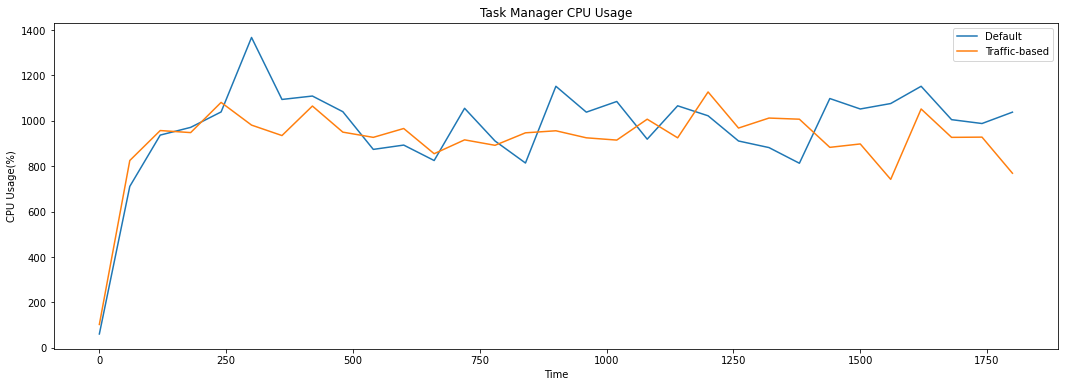

In [9]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(task_tot_cpu_data[0]["rel_time"], task_tot_cpu_data[0]["value"])
ax.plot(task_tot_cpu_data[1]["rel_time"], task_tot_cpu_data[1]["value"])
# ax.plot(task_tot_cpu_data[2]['rel_time'], task_tot_cpu_data[2]['value'])
# ax.plot(task_tot_cpu_data[3]['rel_time'], task_tot_cpu_data[3]['value'])

ax.set(xlabel="Time", ylabel="CPU Usage(%)", title="Task Manager CPU Usage")
ax.tick_params(axis="x", rotation=0)
ax.legend(
    ["Default", "Traffic-based", "Q Actor-Critic", "Actor-Critic NN"], loc="upper right"
)
plt.savefig("task_manager_cpu_usage.png")
plt.show()

In [10]:
individual_cpu_data.head()

,name,time,host,tm_id,value,schedule_mode,rel_time,formatted_time,cpu_id,cpu_usage_name
0,taskmanager_System_CPU_UsageCPU7,2021-03-29 04:04:50.808000+00:00,192.168.152.103,2a2fa18c6cef5208e5b8546fb3f503ac,0.000000,traffic-based,0 days 00:00:00,04:04:50,7,CPU 07 Usage
1,taskmanager_System_CPU_UsageCPU7,2021-03-29 04:04:50.958000+00:00,192.168.152.204,8ec86e66b107819ddb56c18725fbd026,0.000000,traffic-based,0 days 00:00:00.150000,04:04:50,7,CPU 07 Usage
2,taskmanager_System_CPU_UsageCPU7,2021-03-29 04:04:51.187000+00:00,192.168.152.205,275498cbfa76092ed4bd3b828c049d69,0.000000,traffic-based,0 days 00:00:00.379000,04:04:51,7,CPU 07 Usage
3,taskmanager_System_CPU_UsageCPU7,2021-03-29 04:05:20.938000+00:00,192.168.152.103,2a2fa18c6cef5208e5b8546fb3f503ac,28.702011,traffic-based,0 days 00:00:30.130000,04:05:20,7,CPU 07 Usage
4,taskmanager_System_CPU_UsageCPU7,2021-03-29 04:05:21.095000+00:00,192.168.152.204,8ec86e66b107819ddb56c18725fbd026,2.000000,traffic-based,0 days 00:00:30.287000,04:05:21,7,CPU 07 Usage


In [11]:
individual_cpu_data = (
    individual_cpu_data
    .groupby([pd.Grouper(key="rel_time", freq="1min"),
              "host","schedule_mode","cpu_id",
              "cpu_usage_name"])["value"]
    .first()
    .groupby(["rel_time", "host", "schedule_mode", "cpu_id",
              "cpu_usage_name"])
    .sum()
    .reset_index()
)
individual_cpu_data["rel_time"] = individual_cpu_data["rel_time"].dt.seconds

individual_cpu_data

,rel_time,host,schedule_mode,cpu_id,cpu_usage_name,value
0,0,192.168.152.103,default,0,CPU 00 Usage,0.910747
1,0,192.168.152.103,default,1,CPU 01 Usage,0.000000
2,0,192.168.152.103,default,2,CPU 02 Usage,0.545455
3,0,192.168.152.103,default,3,CPU 03 Usage,0.547445
4,0,192.168.152.103,default,4,CPU 04 Usage,0.363636
...,...,...,...,...,...,...
4459,1800,192.168.152.205,traffic-based,19,CPU 19 Usage,0.000000
4460,1800,192.168.152.205,traffic-based,20,CPU 20 Usage,0.728597
4461,1800,192.168.152.205,traffic-based,21,CPU 21 Usage,4.014599
4462,1800,192.168.152.205,traffic-based,22,CPU 22 Usage,1.459854


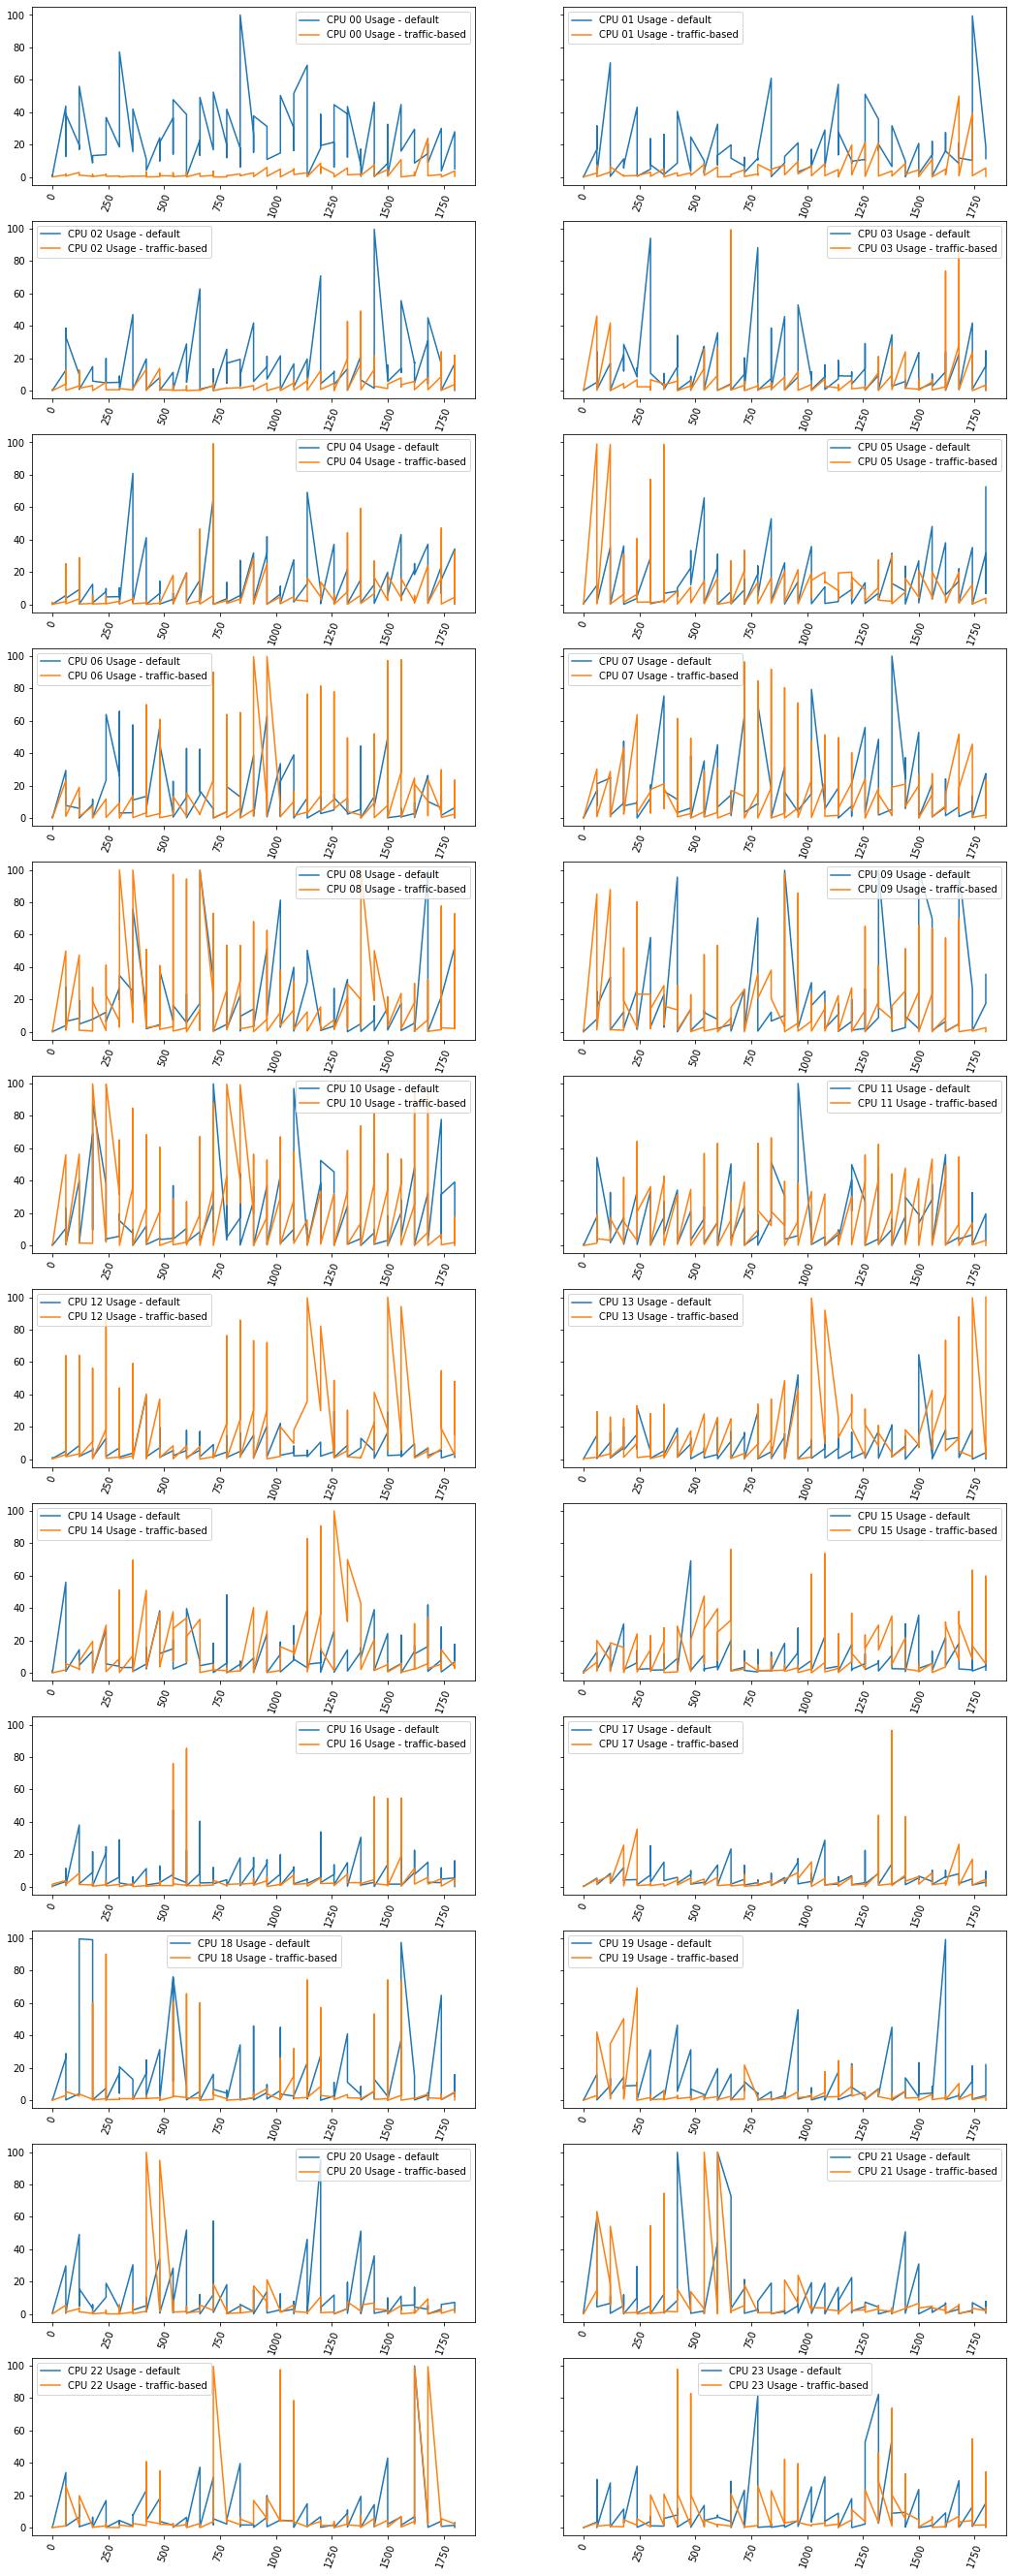

In [14]:
fig, axes = plt.subplots(12, 2, figsize=(18, 48), sharey=True)
loc_placement = "best"
x_tick_rotation = 70

for mode_idx, mode_name in enumerate(schedule_modes):
    mode_cpu_data = individual_cpu_data.loc[
        individual_cpu_data["schedule_mode"] == mode_name
    ]
    for idx, ax in enumerate(axes):
        specific_cpu_data_1 = mode_cpu_data.loc[mode_cpu_data["cpu_id"] == idx * 2]
        specific_cpu_data_2 = mode_cpu_data.loc[
            mode_cpu_data["cpu_id"] == (idx * 2 + 1)
        ]

        label_1 = specific_cpu_data_1.iloc[0]["cpu_usage_name"] + " - " + mode_name
        label_2 = specific_cpu_data_2.iloc[0]["cpu_usage_name"] + " - " + mode_name

        ax[0].plot(
            specific_cpu_data_1["rel_time"],
            specific_cpu_data_1["value"],
            "C" + str(mode_idx),
            label=label_1,
        )
        ax[0].tick_params(axis="x", rotation=x_tick_rotation)
        ax[0].legend(loc=loc_placement)

        ax[1].plot(
            specific_cpu_data_2["rel_time"],
            specific_cpu_data_2["value"],
            "C" + str(mode_idx),
            label=label_2,
        )
        ax[1].tick_params(axis="x", rotation=x_tick_rotation)
        ax[1].legend(loc=loc_placement)

plt.savefig("cpu_usage_metrics.png")

In [15]:
t_op_cpu_use, t_op_rec_in, t_op_rec_out, t_op_rec_proc = load_operator_data_from_csv(0)

# t_op_cpu_use[0] = t_op_cpu_use[0].loc[~t_op_cpu_use[0]['operator_name'].isin(['Sink: count-sink','word-count'])]

for operator_cpu_usage in t_op_cpu_use:
    drop_index = operator_cpu_usage[
        operator_cpu_usage["operator_name"].isin(["Sink: count-sink", "word-count"])
    ].index
    operator_cpu_usage.drop(drop_index, inplace=True)
    operator_cpu_usage["temp_col"] = operator_cpu_usage["operator_name"].str.partition(
        ":"
    )[2]
    operator_cpu_usage.loc[
        operator_cpu_usage["temp_col"] != "", ["operator_name"]
    ] = operator_cpu_usage["temp_col"]
    operator_cpu_usage["formatted_id"] = (
        operator_cpu_usage["operator_name"]
        + "-"
        + operator_cpu_usage["subtask_index"].astype(str)
    )
    operator_cpu_usage.drop(columns=["name", "subtask_index", "temp_col"], inplace=True)
    operator_cpu_usage["value"] = (operator_cpu_usage["value"] / 1000000000.0).round(3)

operator_ids = t_op_cpu_use[0].formatted_id.unique()
print(operator_ids)

for operator_records_in in t_op_rec_in:
    drop_index = operator_records_in[
        operator_records_in["operator_name"].isin(["word-count -> Sink: count-sink"])
    ].index
    operator_records_in.drop(drop_index, inplace=True)
    operator_records_in.loc[
        operator_records_in["operator_name"].str.partition(":")[2] != "",
        ["operator_name"],
    ] = operator_records_in["operator_name"].str.partition(":")[2]
    operator_records_in["formatted_id"] = (
        operator_records_in["operator_name"]
        + "-"
        + operator_records_in["subtask_index"].astype(str)
    )
    operator_records_in.drop(columns=["name", "subtask_index"], inplace=True)

for operator_records_out in t_op_rec_out:
    drop_index = operator_records_out[
        operator_records_out["operator_name"].isin(
            ["Sink: count-sink", "word-count -> Sink: count-sink"]
        )
    ].index
    operator_records_out.drop(drop_index, inplace=True)
    operator_records_out.loc[
        operator_records_out["operator_name"].str.partition(":")[2] != "",
        ["operator_name"],
    ] = operator_records_out["operator_name"].str.partition(":")[2]
    operator_records_out["formatted_id"] = (
        operator_records_out["operator_name"]
        + "-"
        + operator_records_out["subtask_index"].astype(str)
    )
    operator_records_out.drop(columns=["name", "subtask_index"], inplace=True)

t_op_rec_in[0]

Reading taskmanager_job_task_operator_currentCpuUsage_default_2021_03_29.csv into index 0 with schedule mode default
Reading taskmanager_job_task_operator_currentCpuUsage_traffic-based_2021_03_29.csv into index 1 with schedule mode traffic-based
Reading taskmanager_job_task_operator_numRecordsInPerSecond_traffic-based_2021_03_29.csv into index 1 with schedule mode traffic-based
Reading taskmanager_job_task_operator_numRecordsInPerSecond_default_2021_03_29.csv into index 0 with schedule mode default
Reading taskmanager_job_task_operator_numRecordsOutPerSecond_default_2021_03_29.csv into index 0 with schedule mode default
Reading taskmanager_job_task_operator_numRecordsOutPerSecond_traffic-based_2021_03_29.csv into index 1 with schedule mode traffic-based
Reading taskmanager_job_task_operator_numRecordsProcessedPerSecond_default_2021_03_29.csv into index 0 with schedule mode default
Reading taskmanager_job_task_operator_numRecordsProcessedPerSecond_traffic-based_2021_03_29.csv into index

,time,count,host,job_name,operator_id,operator_name,rate,task_attempt_id,task_id,task_name,tm_id,schedule_mode,rel_time,formatted_time,formatted_id
0,2021-03-29 03:30:36.462000+00:00,167961,192.168.152.103,Word Count,0a448493b4782967b150582570326227,word-splitter,2355.350000,a59dbe49a48abcb25c932de2e4d2eacb,0a448493b4782967b150582570326227,word-splitter,4546379e810a5f7f078c6604ac06dc0c,default,0 days 00:00:00,03:30:36,word-splitter-10
1,2021-03-29 03:30:36.462000+00:00,0,192.168.152.103,Word Count,0a448493b4782967b150582570326227,word-splitter,0.000000,b079bf57f7ace9c5ffd7c38c1db0af14,0a448493b4782967b150582570326227,word-splitter,4546379e810a5f7f078c6604ac06dc0c,default,0 days 00:00:00,03:30:36,word-splitter-11
2,2021-03-29 03:30:36.462000+00:00,164156,192.168.152.103,Word Count,0a448493b4782967b150582570326227,word-splitter,2500.983333,3fff1a531ff267b5321274eb6b05c2d8,0a448493b4782967b150582570326227,word-splitter,4546379e810a5f7f078c6604ac06dc0c,default,0 days 00:00:00,03:30:36,word-splitter-14
3,2021-03-29 03:30:36.462000+00:00,82084,192.168.152.103,Word Count,0a448493b4782967b150582570326227,word-splitter,1250.600000,b5dfd568d1a2dfd3eb18efc193867f04,0a448493b4782967b150582570326227,word-splitter,4546379e810a5f7f078c6604ac06dc0c,default,0 days 00:00:00,03:30:36,word-splitter-5
4,2021-03-29 03:30:36.462000+00:00,945880,192.168.152.103,Word Count,604ee7bed040266218075078a35a4449,count-sink,13921.566667,5642ba07518e5ae65be18aa76f642e60,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,4546379e810a5f7f078c6604ac06dc0c,default,0 days 00:00:00,03:30:36,count-sink-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5777,2021-03-29 03:59:43.097000+00:00,59630685,192.168.152.103,Word Count,604ee7bed040266218075078a35a4449,count-sink,33011.250000,5642ba07518e5ae65be18aa76f642e60,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,4546379e810a5f7f078c6604ac06dc0c,default,0 days 00:29:06.635000,03:59:43,count-sink-6
5778,2021-03-29 03:59:43.097000+00:00,25547992,192.168.152.103,Word Count,e70bbd798b564e0a50e10e343f1ac56b,word-count,14151.483333,2e4b013a37d1f93d61e4456446c4113c,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,4546379e810a5f7f078c6604ac06dc0c,default,0 days 00:29:06.635000,03:59:43,word-count-3
5779,2021-03-29 03:59:43.097000+00:00,0,192.168.152.103,Word Count,bc764cd8ddf7a0cff126f51c16239658,sentence-stream,0.000000,d7f7f5e59926612f71efb7f2139d86f3,bc764cd8ddf7a0cff126f51c16239658,Source: sentence-stream,4546379e810a5f7f078c6604ac06dc0c,default,0 days 00:29:06.635000,03:59:43,sentence-stream-2
5780,2021-03-29 03:59:43.097000+00:00,12745936,192.168.152.103,Word Count,604ee7bed040266218075078a35a4449,count-sink,7088.316667,562c4a45b4a9604692a5dfe67864e6ed,e70bbd798b564e0a50e10e343f1ac56b,word-count -> Sink: count-sink,4546379e810a5f7f078c6604ac06dc0c,default,0 days 00:29:06.635000,03:59:43,count-sink-4


In [16]:
rec_proc_list_data = (
    t_op_rec_proc[0]
    .groupby([pd.Grouper(key="rel_time", freq="1min"), "edge_name"])["rate"]
    .agg(lambda x: list(x))
    .reset_index()
)
rec_proc_list_data["length"] = rec_proc_list_data["rate"].str.len()

rec_proc_plot_data = (
    t_op_rec_proc[0]
    .groupby([pd.Grouper(key="rel_time", freq="1min"), "schedule_mode", "edge_name"])[
        "rate"
    ]
    .first()
    .reset_index()
    .groupby(["rel_time", "schedule_mode"])
    .sum()
    .reset_index()
)
rec_proc_plot_data

,rel_time,schedule_mode,rate
0,0 days 00:00:00,default,344585.450000
1,0 days 00:01:00,default,752455.200000
2,0 days 00:02:00,default,720003.700000
3,0 days 00:03:00,default,764620.050000
4,0 days 00:04:00,default,775946.666667
5,0 days 00:05:00,default,780312.566667
6,0 days 00:06:00,default,785198.483333
7,0 days 00:07:00,default,756785.766667
8,0 days 00:08:00,default,777316.183333
9,0 days 00:09:00,default,752032.600000


In [17]:
grouped_operator_rec_in = []
grouped_operator_rec_out = []
grouped_operator_rec_proc = []

for operator_records_in in t_op_rec_in:
    grouped_operator_rec_in.append(
        operator_records_in.groupby(
            [
                pd.Grouper(key="rel_time", freq="1min"),
                "schedule_mode",
                "operator_name",
                "formatted_id",
            ]
        )["rate"]
        .first()
        .groupby(["rel_time", "schedule_mode", "operator_name"])
        .sum()
        .reset_index()
    )

for operator_records_out in t_op_rec_out:
    grouped_operator_rec_out.append(
        operator_records_out.groupby(
            [
                pd.Grouper(key="rel_time", freq="1min"),
                "schedule_mode",
                "operator_name",
                "formatted_id",
            ]
        )["rate"]
        .first()
        .groupby(["rel_time", "schedule_mode", "operator_name"])
        .sum()
        .reset_index()
    )

for operator_records_proc in t_op_rec_proc:
    grouped_operator_rec_proc.append(
        operator_records_proc.groupby(
            [pd.Grouper(key="rel_time", freq="1min"), "schedule_mode", "edge_name"]
        )["rate"]
        .first()
        .groupby(["rel_time", "schedule_mode"])
        .sum()
        .reset_index()
    )

for i in range(len(grouped_operator_rec_proc)):
    grouped_operator_rec_in[i]["rel_time"] = grouped_operator_rec_in[i]["rel_time"].dt.seconds
    grouped_operator_rec_out[i]["rel_time"] = grouped_operator_rec_out[i]["rel_time"].dt.seconds
    grouped_operator_rec_proc[i]["rel_time"] = grouped_operator_rec_proc[i]["rel_time"].dt.seconds

in_operator_names = grouped_operator_rec_in[0].operator_name.unique()
out_operator_names = grouped_operator_rec_out[0].operator_name.unique()
grouped_operator_rec_proc[0].head(50)

,rel_time,schedule_mode,rate
0,0,default,344585.450000
1,60,default,752455.200000
2,120,default,720003.700000
3,180,default,764620.050000
4,240,default,775946.666667
5,300,default,780312.566667
6,360,default,785198.483333
7,420,default,756785.766667
8,480,default,777316.183333
9,540,default,752032.600000


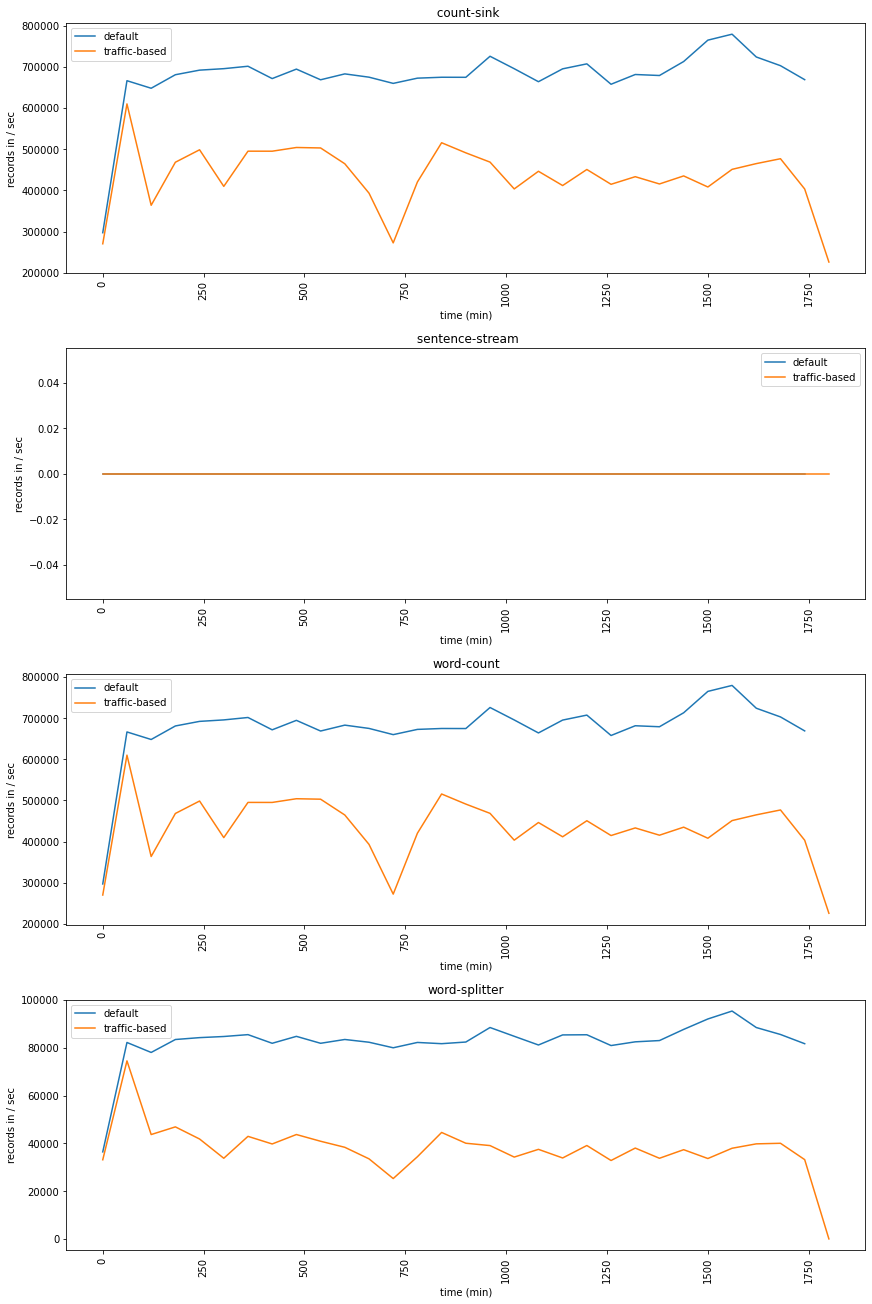

In [18]:
fig, axes = plt.subplots(
    len(in_operator_names), figsize=(12, 18), constrained_layout=True
)
x_tick_rotation = 90

for idx, ax in enumerate(axes):
    label_1 = in_operator_names[idx]
    ax.set_title(label_1)
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_in_dataset in grouped_operator_rec_in:
        specific_op_rec_in = grp_op_rec_in_dataset.loc[
            grp_op_rec_in_dataset["operator_name"] == in_operator_names[idx]
        ]
        schedule_mode = specific_op_rec_in["schedule_mode"].unique()[0]
        ax.plot(
            specific_op_rec_in["rel_time"],
            specific_op_rec_in["rate"],
            label=schedule_mode,
        )
        ax.set_xlabel("time (min)")
        ax.set_ylabel("records in / sec")

        ax.legend(loc="best")

plt.savefig("operator_metrics_in.png")

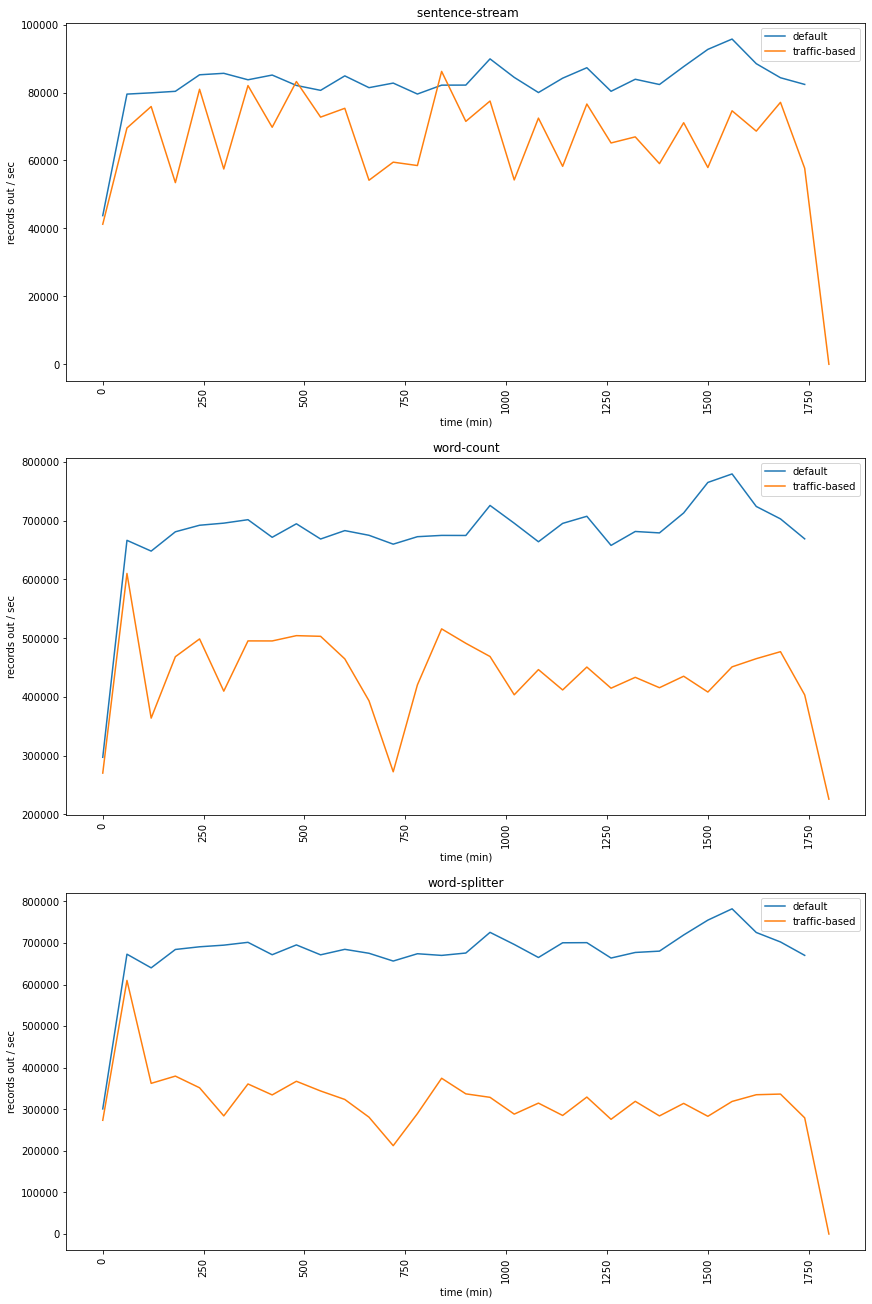

In [19]:
fig, axes = plt.subplots(
    len(out_operator_names), figsize=(12, 18), constrained_layout=True
)
loc_placement = "upper right"
x_tick_rotation = 90

for idx, ax in enumerate(axes):
    label_1 = out_operator_names[idx]
    ax.set_title(label_1)
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_out_dataset in grouped_operator_rec_out:
        specific_op_rec_out = grp_op_rec_out_dataset.loc[
            grp_op_rec_out_dataset["operator_name"] == out_operator_names[idx]
        ]
        schedule_mode = specific_op_rec_out["schedule_mode"].unique()[0]
        ax.plot(
            specific_op_rec_out["rel_time"],
            specific_op_rec_out["rate"],
            label=schedule_mode,
        )
    ax.set_xlabel("time (min)")
    ax.set_ylabel("records out / sec")
    ax.legend(loc="best")

plt.savefig("operator_metrics_out.png")

In [20]:
grouped_operator_rec_proc[0]

,rel_time,schedule_mode,rate
0,0,default,344585.450000
1,60,default,752455.200000
2,120,default,720003.700000
3,180,default,764620.050000
4,240,default,775946.666667
5,300,default,780312.566667
6,360,default,785198.483333
7,420,default,756785.766667
8,480,default,777316.183333
9,540,default,752032.600000


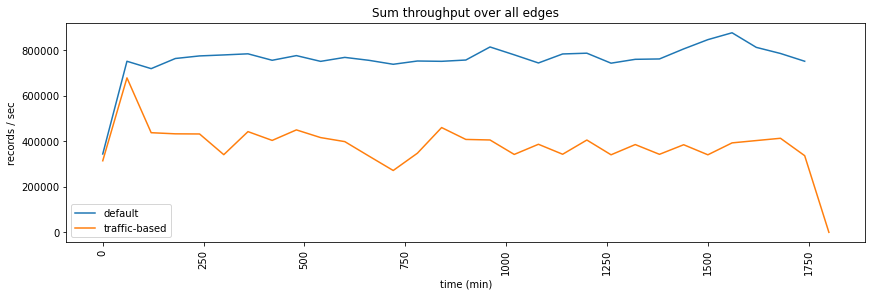

In [21]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
x_tick_rotation = 90

ax.set_title("Sum throughput over all edges")
ax.tick_params(axis="x", rotation=x_tick_rotation)
for grp_op_rec_proc_dataset in grouped_operator_rec_proc:
    schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
    ax.plot(
        grp_op_rec_proc_dataset["rel_time"],
        grp_op_rec_proc_dataset["rate"],
        label=schedule_mode,
    )

    ax.set_xlabel("time (min)")
    ax.set_ylabel("records / sec")

ax.legend(loc="best")

plt.savefig("operator_metrics_proc.pdf")

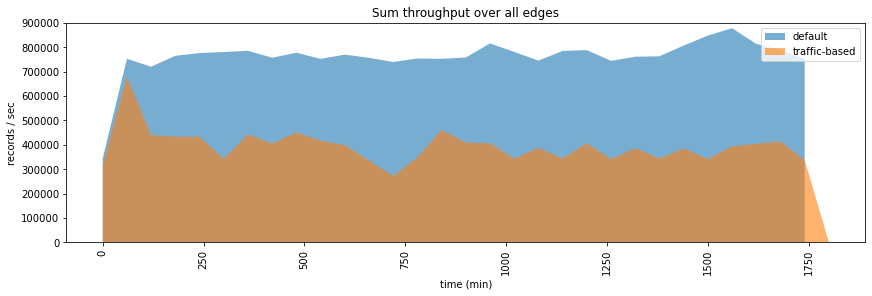

In [22]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
x_tick_rotation = 90

ax.set_title("Sum throughput over all edges")
ax.tick_params(axis="x", rotation=x_tick_rotation)
for grp_op_rec_proc_dataset in grouped_operator_rec_proc:
    schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
    ax.fill_between(
        grp_op_rec_proc_dataset["rel_time"],
        grp_op_rec_proc_dataset["rate"],
        label=schedule_mode,
        alpha=0.6,
    )
    ax.set_xlabel("time (min)")
    ax.set_ylabel("records / sec")

ax.legend(loc="best")
plt.ylim(0, 900000)

plt.savefig("operator_metrics_proc_short_y.png")
plt.savefig("operator_metrics_proc_short_y.pdf")

In [23]:
for grp_op_rec_proc_dataset in grouped_operator_rec_proc:
    schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
    print(
        "AUC ({}) : \t{:,.2f}".format(
            schedule_mode,
            auc(
                grp_op_rec_proc_dataset["rel_time"],
                grp_op_rec_proc_dataset["rate"],
            ),
        )
    )

AUC (default) : 	1,335,342,011.00
AUC (traffic-based) : 	699,033,870.00


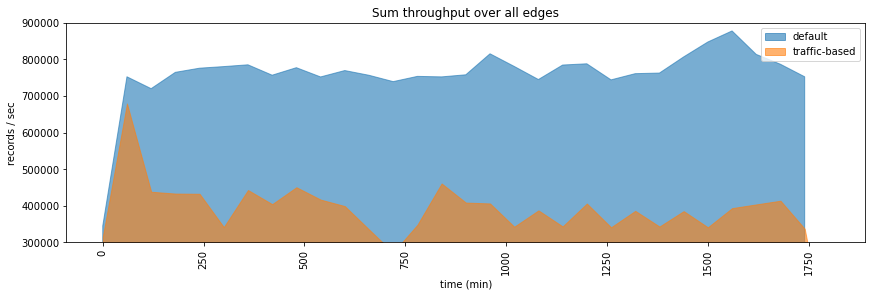

In [29]:
if len(grouped_operator_rec_proc) > 1:
    fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
    loc_placement = "upper right"
    x_tick_rotation = 90

    ax.set_title("Sum throughput over all edges")
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_proc_dataset in [grouped_operator_rec_proc[i] for i in [0, 1]]:
        schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
        mode_color = "C0"
        if schedule_mode == "traffic-based":
            mode_color = "C1"
        elif schedule_mode == "Q-actor-critic":
            mode_color = "C2"
        elif schedule_mode == "actor-critic-NN":
            mode_color = "C3"
        ax.fill_between(
            grp_op_rec_proc_dataset["rel_time"],
            grp_op_rec_proc_dataset["rate"],
            label=schedule_mode,
            alpha=0.6,
            color=mode_color,
        )
        ax.set_xlabel("time (min)")
        ax.set_ylabel("records / sec")

    ax.legend(loc="best")
    plt.ylim(300000, 900000)

    plt.savefig("operator_metrics_proc_short_y_traffic_based.pdf")

In [25]:
if len(grouped_operator_rec_proc) > 2:
    fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
    loc_placement = "upper right"
    x_tick_rotation = 90

    ax.set_title("Sum throughput over all edges")
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_proc_dataset in [grouped_operator_rec_proc[i] for i in [0, 2]]:
        schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
        mode_color = "C0"
        if schedule_mode == "traffic-based":
            mode_color = "C1"
        elif schedule_mode == "Q-actor-critic":
            mode_color = "C2"
        elif schedule_mode == "actor-critic-NN":
            mode_color = "C3"
        ax.fill_between(
            grp_op_rec_proc_dataset["rel_time"],
            grp_op_rec_proc_dataset["rate"],
            label=schedule_mode,
            alpha=0.6,
            color=mode_color,
        )
        ax.set_xlabel("time (min)")
        ax.set_ylabel("records / sec")

    ax.legend(loc="best")
    plt.ylim(300000, 450000)

    plt.savefig("operator_metrics_proc_short_y_drl_based.pdf")

In [26]:
if len(grouped_operator_rec_proc) > 3:
    fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
    loc_placement = "upper right"
    x_tick_rotation = 90

    ax.set_title("Sum throughput over all edges")
    ax.tick_params(axis="x", rotation=x_tick_rotation)
    for grp_op_rec_proc_dataset in [grouped_operator_rec_proc[i] for i in [0, 3]]:
        schedule_mode = grp_op_rec_proc_dataset["schedule_mode"].unique()[0]
        mode_color = "C0"
        if schedule_mode == "traffic-based":
            mode_color = "C1"
        elif schedule_mode == "Q-actor-critic":
            mode_color = "C2"
        elif schedule_mode == "actor-critic-NN":
            mode_color = "C3"
        ax.fill_between(
            grp_op_rec_proc_dataset["rel_time"],
            grp_op_rec_proc_dataset["rate"],
            label=schedule_mode,
            alpha=0.6,
            color=mode_color,
        )
        ax.set_xlabel("time (min)")
        ax.set_ylabel("records / sec")

    ax.legend(loc="best")
    plt.ylim(300000, 450000)

    plt.savefig("operator_metrics_proc_short_y_adaptive.pdf")

In [28]:
print("Done.")

Done.
